# Image Segmentation with Deep Learning




Author: Hayden Suwaed

Email: haidersuwaed@gmail.com



Date: Apr-1-2023



## Table of Contents

[1. Introduction](#Intorduction) <br>
[2. Modeling](#Modeling) <br>
[3. Conclusions](#Conclusions)



## Introduction

"Deep learning neural networks are brain-inspired networks that are used to recognize patterns." - *Fei-Fei Li* 

Brain tumor segmentation is a critical task in medical image analysis, which entails the precise delineation of tumor regions from healthy brain tissues in magnetic resonance imaging (MRI) scans. Accurate segmentation is vital for diagnosis, treatment planning, and monitoring the progress of patients with brain tumors. Deep learning has emerged as a powerful tool for tackling this challenging problem, with Convolutional Neural Networks (CNNs) and other sophisticated architectures exhibiting remarkable performance in identifying, localizing, and classifying different tumor sub-regions.**The primary goal of utilizing deep learning algorithms for brain tumor segmentation is to achieve unparalleled accuracy in detecting and delineating tumor regions, thereby facilitating timely diagnosis and personalized treatment plans for improved patient outcomes.**

## 1. Data Collection and Description

In this study, we will utilize a dataset consisting of images and their corresponding masks in the Joint Photographic Experts Group (JPEG) format. The dataset was procured and preprocessed by Southern Medical University, located in Guangzhou, Guangdong, China. The dataset was originally released on April 2, 2017.


The brain tumor dataset comprises 3,064 T1-weighted contrast-enhanced images derived from 233 patients diagnosed with three distinct brain tumor types: meningioma (708 slices), glioma (1,426 slices), and pituitary tumor (930 slices). Owing to repository file size constraints, the dataset has been partitioned into four subsets and compressed into four separate .zip files, each containing 766 slices. Additionally, the dataset includes indices for 5-fold cross-validation to facilitate model evaluation and comparison.



Check out the dataset that have bee used for this project [Here](https://drive.google.com/drive/folders/1nAu70XoU7Wln8nY1OC7zhfr7n5f0rYlf?usp=share_link)

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation,\
MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout, GaussianNoise, concatenate
from tensorflow.keras.models import Model
# from focal_loss import BinaryFocalLoss


import os
import random
import numpy as np
import pandas as pd
from glob import glob
import pandas as pd

 
from tqdm import tqdm 
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

The following code utilizes the TensorFlow library to detect and list the physical and logical graphics processing units (GPUs) available in the system. It then sets the memory growth parameter to True for each available GPU, which allows for dynamic allocation of only necessary GPU memory during computation. The code is enclosed in a try-except block to handle any runtime errors. Finally, the code prints the number of physical and logical GPUs detected in the system.

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-03-19 17:25:51.308388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-19 17:25:51.308628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-19 17:25:51.335628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-19 17:25:51.335838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-19 17:25:51.336092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Here we set the values of `IMG_WIDTH`, `IMG_HEIGHT`, and `IMG_CHANNELS` to 128, 128, and 3, respectively. These variables are commonly used in image processing and computer vision applications to define the dimensions and number of channels of an image.

In [5]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

The `seed` variable is set to 42, which is a commonly used value in random number generation. The `batch_size` is set to 10, which specifies the number of samples to use for each training update. The `lr` variable defines the learning rate of the optimizer and is set to 1e-4, and the `optimizer` is defined using the Adam optimizer from the Keras library with the specified learning rate. `num_epochs` is set to 60, which specifies the number of times the training process should iterate over the entire dataset. Finally,`model_path` and `csv_path` specify the file paths for saving the best model and logging the training metrics, respectively.

In [6]:
seed=42
batch_size = 10
lr = 1e-4
optimizer =tf.keras.optimizers.Adam(lr)
num_epochs = 100
model_path = os.path.join("files", "best_model.h5")
csv_path = os.path.join("files", "log.csv")

## 2. Loading and Preprocessing Data


Here wedefine a function named `load_dataset` that takes a `path` argument, which specifies the location of the dataset images and masks. The function also allows for specifying the `val_split` and `test_split` proportions for splitting the dataset into validation and test sets. The function first retrieves the images and masks from the specified paths using `glob` and sorts them. It then calculates the validation and test set sizes and splits the data accordingly using `train_test_split` from the Scikit-learn library. Finally, the function returns the training, validation, and test data as tuples of `(images, masks)` for each set.

In [7]:
def load_dataset(path, val_split=0.1, test_split=0.05, image_format="jpg"):
    image_format = image_format
    images = sorted(glob(os.path.join(path, "images", f"*.{image_format}")))
    masks = sorted(glob(os.path.join(path, "masks", f"*.{image_format}")))

    val_split_size = int(len(images) * val_split)
    test_split_size = int(len(images) * test_split)

    train_x, valid_x = train_test_split(images, test_size=val_split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=val_split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

As you can see, `np.random.seed(42)` sets the NumPy random seed to 42, which ensures that the same sequence of random numbers will be generated on each run. `tf.random.set_seed(42)` sets the TensorFlow random seed to 42, which ensures that the model will be initialized with the same set of random weights on each run, allowing for reproducibility of results.

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

We are checking if a directory named 'files/' exists, and creates one if it does not exist, using the `os` module. The following commented line is used to print the current working directory path using the `pwd` command.

In [9]:
if os.path.exists('files/') == False:
  os.mkdir('files/')
if os.path.exists('output_results/') == False:
  os.mkdir('output_results/')

# os.chdir('/content/drive/MyDrive/BT_Seg_Unet')
!pwd

/home/ahmed/Downloads/unet_aug_tl


`dataset_path`, `image_path`, and `mask_path` variables store the paths to the dataset and the corresponding image and mask directories. The `load_dataset()` function is used to load and split the data into training, validation, and test sets and returns them as tuples of `(images, masks)` for each set. The returned values are then unpacked and stored in `(train_x, train_y)`, `(valid_x, valid_y)`, `(test_x, test_y)` variables.

In [10]:
dataset_path = "/content/drive/MyDrive/Brain_MRI_Segmentation/dataset"
image_path = '/content/drive/MyDrive/Brain_MRI_Segmentation/dataset/images/'
mask_path = '/content/drive/MyDrive/Brain_MRI_Segmentation/dataset/masks/'
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path, image_format='jpg')

In [11]:
# Sanity check
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(f"Test : {len(test_x)} - {len(test_y)}")

Train: 2605 - 2605
Valid: 306 - 306
Test : 153 - 153


The below code creates a pandas DataFrame object `train_x_df` containing the paths to the training images, splits the paths by '/' using `str.split()` function, stores the resulting parts in separate columns, and sorts the column containing the names of the subdirectories in ascending order.

In [12]:
train_x_df=pd.DataFrame(train_x, columns=['path'])
train_x_df = train_x_df.path.str.split("/", expand=True)
train_x_df[2]=train_x_df[2].sort_values()
train_x_df.head()

,0,1,2
0,dataset,images,103582_pituitary_1634.jpg
1,dataset,images,101724_pituitary_1933.jpg
2,dataset,images,104684_pituitary_1104.jpg
3,dataset,images,112847_pituitary_70.jpg
4,dataset,images,MR026175E_glioma_337.jpg


The following code creates a pandas DataFrame object containing the paths to the training masks and splits the paths by '/' using `str.split()`, storing the resulting parts in separate columns, and sorting the column containing the names of the subdirectories in ascending order.

In [13]:
train_y_df=pd.DataFrame(train_y, columns=['path'])
train_y_df = train_y_df.path.str.split("/", expand=True)
train_y_df[2]=train_y_df[2].sort_values()
train_y_df.head()

,0,1,2
0,dataset,masks,103582_pituitary_1634.jpg
1,dataset,masks,101724_pituitary_1933.jpg
2,dataset,masks,104684_pituitary_1104.jpg
3,dataset,masks,112847_pituitary_70.jpg
4,dataset,masks,MR026175E_glioma_337.jpg


Here we create a pandas DataFrame object containing the paths to the validation images, splits the paths by '/' using `str.split()`, storing the resulting parts in separate columns, and sorts the column containing the names of the subdirectories in ascending order.

In [14]:
valid_x_df=pd.DataFrame(valid_x, columns=['path'])
valid_x_df = valid_x_df.path.str.split("/", expand=True)
valid_x_df[2]=valid_x_df[2].sort_values()
valid_x_df.head()

,0,1,2
0,dataset,images,112552_meningioma_88.jpg
1,dataset,images,102075_glioma_739.jpg
2,dataset,images,112649_pituitary_2472.jpg
3,dataset,images,97890_pituitary_67.jpg
4,dataset,images,97607_meningioma_477.jpg


Here we create a pandas DataFrame object containing the paths to the validation masks, splits the paths by '/' using `str.split()`, storing the resulting parts in separate columns, and sorts the column containing the names of the subdirectories in ascending order.

In [15]:
valid_y_df=pd.DataFrame(valid_y, columns=['path'])
valid_y_df = valid_y_df.path.str.split("/", expand=True)
valid_y_df[2]=valid_y_df[2].sort_values()
valid_y_df.head()

,0,1,2
0,dataset,masks,112552_meningioma_88.jpg
1,dataset,masks,102075_glioma_739.jpg
2,dataset,masks,112649_pituitary_2472.jpg
3,dataset,masks,97890_pituitary_67.jpg
4,dataset,masks,97607_meningioma_477.jpg


## Data Augmentation


Here we need to initialize a random seed and imports the `ImageDataGenerator` class from the Keras library to define `img_data_gen_args` and `mask_data_gen_args` which specify the data augmentation parameters for images and masks, respectively. Two `ImageDataGenerator` objects are then created using these dictionaries. These generators are used to flow data from the dataframes of training and validation images and masks into the model. The `flow_from_dataframe()` function creates a generator that yields batches of augmented images and masks during training and validation. The `color_mode` parameter specifies the color channel format of the images and masks, and the `target_size` parameter defines the desired size of the images and masks after augmentation.

In [31]:
seed=42
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=30,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect') 

mask_data_gen_args = dict(rotation_range=30,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect') 
image_data_generator = ImageDataGenerator(**img_data_gen_args)
# image_data_generator.fit(X_train, augment=True, seed=seed)
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
# mask_data_generator.fit(Y_train, augment=True, seed=seed)

image_generator = image_data_generator.flow_from_dataframe(dataframe=train_x_df, x_col=2, directory=image_path, class_mode=None, seed=seed,color_mode="rgb", batch_size=batch_size, target_size=(IMG_WIDTH,IMG_HEIGHT))
mask_generator = mask_data_generator.flow_from_dataframe(dataframe=train_y_df, x_col=2, directory=mask_path, class_mode=None, seed=seed,color_mode="grayscale", batch_size=batch_size, target_size=(IMG_WIDTH,IMG_HEIGHT))

valid_img_generator = image_data_generator.flow_from_dataframe(dataframe=valid_x_df, x_col=2, directory=image_path, class_mode=None, seed=seed,color_mode="rgb", batch_size=batch_size, target_size=(IMG_WIDTH,IMG_HEIGHT))
valid_mask_generator = mask_data_generator.flow_from_dataframe(dataframe=valid_y_df, x_col=2, directory=mask_path, class_mode=None, seed=seed,color_mode="grayscale", batch_size=batch_size, target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 2605 validated image filenames.
Found 2605 validated image filenames.
Found 306 validated image filenames.
Found 306 validated image filenames.


In [1]:
# Sanity check
print(f"Train: {len(image_generator)}")
print(f"Valid: {len(valid_img_generator)}")

NameError: name 'image_generator' is not defined

In [33]:
# check image & mask dimensions
image_generator[1][0].shape, mask_generator[1][0].shape

((128, 128, 3), (128, 128, 1))

In [34]:
valid_img_generator[1][0].shape, valid_mask_generator[1][0].shape

((128, 128, 3), (128, 128, 1))

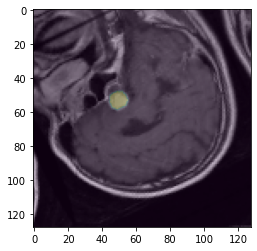

In [30]:
# sanity check
i=np.random.randint(0, len(image_generator) - 1)
j=np.random.randint(0, batch_size - 1)
plt.imshow(image_generator[i][j]/255)
plt.imshow(mask_generator[i][j], alpha=0.2)

The code below defines two functions: `adjust_data` and `my_image_mask_generator`. `adjust_data` normalizes the pixel values of an image and its corresponding mask and returns a tuple containing the normalized image and binary mask. `my_image_mask_generator` takes two generators and generates pairs of normalized images and binary masks by iterating through the generators and calling `adjust_data` for each pair. The function yields each pair as a tuple. The code can be used to prepare input data for deep learning models.

In [37]:
# Normalising image pixel values to range 0-1 and convert masks pixels to 1 or 0 only (binarize)
def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255
    mask[mask > 0] = 1
    mask[mask <= 0] = 0
    return (img, mask)
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
         img, mask = adjust_data(img, mask)
         yield (img, mask)

The code below initializes the training and validation datasets using the custom generator function `my_image_mask_generator()`. The `train_dataset` is created by calling `my_image_mask_generator()` with the `image_generator` and `mask_generator`, while valid_dataset is created by calling `my_image_mask_generator()` with `valid_img_generator` and `valid_mask_generator`. These generators yield pairs of augmented images and masks during training and validation.

In [38]:
train_dataset = my_image_mask_generator(image_generator, mask_generator)
valid_dataset = my_image_mask_generator(valid_img_generator, valid_mask_generator)

We need to calculate the number of batches in the training and validation datasets using `steps_per_epoch` and `val_steps` variables, respectively. `steps_per_epoch` is calculated by multiplying the length of `train_x` by 3 and dividing the result by batch_size. Similarly, `val_steps` is calculated by multiplying the length of `valid_x` by 3 and dividing the result by `batch_size`. These variables are used to specify the number of training and validation steps during model training.

In [39]:
steps_per_epoch = 3*(len(train_x))//batch_size
val_steps = 3*(len(valid_x))//batch_size

Her we need to define three functions: `dice_coef`, `dice_loss`, and `iou`, which are used to evaluate the performance of a segmentation model.

- `dice_coef` calculates the dice coefficient between the ground truth mask and predicted mask using the intersection of the two masks.

- `dice_loss` returns the complement of the dice coefficient, which is used as a loss function.

- `iou` calculates the intersection-over-union metric between the ground truth mask and predicted mask using the intersection and sum of the masks.

These functions can be used to evaluate the accuracy of segmentation models during training or testing.

In [40]:
# Evaluation metrics: dice coefficient 
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Evaluation metrics: iou
def iou(y_true, y_pred, smooth = 1.):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true) + K.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

## Modeling

In this project, we will use a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg called **VGG16**

**The 16 in VGG16** refers to 16 **layers** that have **weights**. In **VGG16** there are thirteen convolutional layers , five Max Pooling layers, and three Dense layers which sum up to 21 layers but it has only sixteen weight layers i.e., learnable parameters layer.

**VGG16** is a convolutional neural network model that's used for image recognition. It's unique in that it has only 16 layers that have weights, as opposed to relying on a large number of hyper-parameters. It's considered one of the best vision model architectures.

- It includes convolutional layers, max pooling, flattening, and fully connected layers
- `Max pooling` is used to downsample the feature maps and reduce the input dimensionality
- Flattening transforms the multidimensional tensor into a single long vector
- Fully connected layers transform the flattened output into class scores
- The last layer uses softmax to convert the scores into a probability distribution over possible classes
- `VGG16` is a powerful tool for image recognition and classification tasks

<img src=https://dl.acm.org/cms/attachment/75ba2dda-9f47-427a-87bf-bcd4ac6627b3/image7.jpg
     align="middle"
     width=800/>

Here we have a function that returns an instance of a U-Net model with VGG16 pre-trained weights for image segmentation. The VGG16 model is loaded with pre-trained weights from ImageNet and its layers are frozen to avoid retraining. The U-Net model consists of four up-sampling blocks, each with a transposed convolution layer followed by two convolution layers. The final layer is a 1x1 convolution layer with sigmoid activation to output the segmentation mask. Finally, an instance of the TL_unet_model is created and its summary is printed. Overall, this code creates a powerful image segmentation model using pre-trained weights.

In [41]:
# Unet pre-trained model with VGG16 (weights: imagenet) 
def TL_unet_model(input_shape):
    # input: input_shape (height, width, channels) 
    # return model
    input_shape = input_shape
    base_VGG = VGG16(include_top = False, 
                   weights = "imagenet", 
                   input_shape = input_shape)

    # freezing all layers in VGG16 
    for layer in base_VGG.layers: 
        layer.trainable = False

    # the bridge (exclude the last maxpooling layer in VGG16) 
    bridge = base_VGG.get_layer("block5_conv3").output
    print(bridge.shape)

    # Decoder 
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    print(up1.shape)
    concat_1 = concatenate([up1, base_VGG.get_layer("block4_conv3").output], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat_1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    print(up2.shape)
    concat_2 = concatenate([up2, base_VGG.get_layer("block3_conv3").output], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat_2)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    print(up3.shape)
    concat_3 = concatenate([up3, base_VGG.get_layer("block2_conv2").output], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    print(up4.shape)
    concat_4 = concatenate([up4, base_VGG.get_layer("block1_conv2").output], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat_4)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    print(conv10.shape)

    model_ = Model(inputs=[base_VGG.input], outputs=[conv10], name='TL_UNET')

    return model_
model = TL_unet_model((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
model.summary()


(None, 8, 8, 512)
(None, 16, 16, 512)
(None, 32, 32, 256)
(None, 64, 64, 128)
(None, 128, 128, 64)
(None, 128, 128, 1)
Model: "TL_UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block

The code snippet provided compiles a Keras model with a specified optimizer, loss function, and various evaluation metrics.

- The `optimizer` is a pre-defined optimization algorithm used for training the model by updating its weights to minimize the loss.
- The `loss` function is set to `binary_crossentropy`, which is commonly used for binary classification tasks. This function measures the difference between the true labels and the predicted probabilities.
- The `metrics` parameter is a list of evaluation metrics used to assess the model's performance during training and validation. In this case, the metrics include:
    - `dice_coef`: The Dice coefficient, which measures the similarity between two sets of binary data. It is often used to evaluate segmentation models.
    -`accuracy`: The proportion of correctly classified instances out of the total instances.
    - `tf.keras.metrics.BinaryIoU(threshold=0.5)`: The Intersection over Union (IoU) metric with a threshold of 0.5, which measures the overlap between the predicted and true binary masks.

In [42]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[dice_coef,'accuracy', tf.keras.metrics.BinaryIoU(threshold=0.5)])

We need to define a list of Keras callbacks for model training:

- `ModelCheckpoint`: Saves the best model weights based on validation loss.
- `ReduceLROnPlateau`: Reduces the learning rate when validation loss stops improving.
- `CSVLogger`: Logs epoch results to a CSV file.
- `EarlyStopping`: Stops training when validation loss stops improving after a specified number of epochs.

In [43]:
callbacks = [
        tf.keras.callbacks.ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-9, verbose=1),
        tf.keras.callbacks.CSVLogger(csv_path),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    ]

WE have here Keras model using the fit method with the following parameters:

- `train_dataset`: The training dataset.
- `steps_per_epoch`: Number of steps per epoch.
- `num_epochs`: Total number of training epochs.
- `validation_data`: The validation dataset.
- `validation_steps`: Number of steps per validation epoch.
- `callbacks`: A list of Keras callbacks to monitor and adjust training behavior.

In [44]:
model = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=num_epochs,
        validation_data=valid_dataset,
        validation_steps=steps_per_epoch,
        callbacks=callbacks
    )

Epoch 1/100


2023-03-19 17:27:41.569408: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8500
2023-03-19 17:27:42.102378: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


781/781 [==============================] - ETA: 0s - loss: 0.0697 - dice_coef: 0.3837 - accuracy: 0.9767 - binary_io_u: 0.6208
Epoch 1: val_loss improved from inf to 0.04630, saving model to files/best_model.h5
781/781 [==============================] - 122s 151ms/step - loss: 0.0697 - dice_coef: 0.3837 - accuracy: 0.9767 - binary_io_u: 0.6208 - val_loss: 0.0463 - val_dice_coef: 0.4897 - val_accuracy: 0.9841 - val_binary_io_u: 0.6649 - lr: 1.0000e-04
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.0341 - dice_coef: 0.5773 - accuracy: 0.9876 - binary_io_u: 0.7532
Epoch 2: val_loss improved from 0.04630 to 0.03226, saving model to files/best_model.h5
781/781 [==============================] - 117s 150ms/step - loss: 0.0341 - dice_coef: 0.5773 - accuracy: 0.9876 - binary_io_u: 0.7532 - val_loss: 0.0323 - val_dice_coef: 0.6212 - val_accuracy: 0.9881 - val_binary_io_u: 0.7700 - lr: 1.0000e-04
Epoch 3/100
781/781 [==============================] - ETA: 0s - loss: 0.0

This code plots the model performance metrics during training and validation such as `Accuracy`, `Loss`, `Dice-coef`, and `IOU` (**Intersection over Union**). It first determines the number of epochs using the length of the model's history. Then it sets the step size based on the number of epochs. The plots are created using subplots, and the training and validation metrics are plotted against the number of epochs on the `x-axis`. The `y-axis` represents the corresponding metric value. Legends are added to differentiate between the training and validation metrics. Finally, all four subplots are shown.

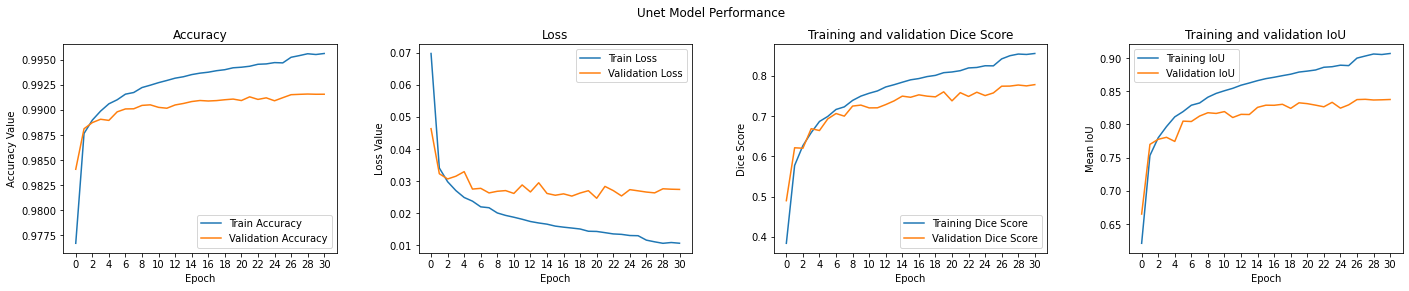

In [45]:
# plot train, validation Accuracy, Loss, Dice-coef and IOU
num_epochs = len(model.history['accuracy'])
step = 2
if num_epochs > 35:
    step = 5

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 4))
t = f.suptitle('VGG16 Model Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,num_epochs))
ax1.plot(epoch_list, model.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, model.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, num_epochs, step))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, model.history['loss'], label='Train Loss')
ax2.plot(epoch_list, model.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, num_epochs, step))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

epoch_list = list(range(0,num_epochs))
ax3.plot(epoch_list, model.history['dice_coef'], label='Training Dice Score')
ax3.plot(epoch_list, model.history['val_dice_coef'], label='Validation Dice Score')
ax3.set_xticks(np.arange(0, num_epochs, step))
ax3.set_ylabel('Dice Score')
ax3.set_xlabel('Epoch')
ax3.set_title('Training and validation Dice Score')
l3 = ax3.legend(loc="best")

ax4.plot(epoch_list, model.history['binary_io_u'], label='Training IoU')
ax4.plot(epoch_list, model.history['val_binary_io_u'], label='Validation IoU')
ax4.set_xticks(np.arange(0, num_epochs, step))
ax4.set_ylabel('Mean IoU')
ax4.set_xlabel('Epoch')
ax4.set_title('Training and validation IoU')
l4 = ax4.legend(loc="best")

We now need to load a pre-trained Keras model from the`best_model.h` file located in the `files` directory. The`CustomObjectScope` context is used to pass the custom functions `dice_coef` and "dice_loss" which are used to compile the model. The "compile" flag is set to `False`, indicating that the model will not be **re-compiled** after loading. The loaded model is stored in the variable `model`.

In [46]:
#Load the model
# with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
model = tf.keras.models.load_model(os.path.join("files", "best_model.h5"), compile=False)

Here we select a random image and its corresponding mask from the test set, resizes the image to the appropriate dimensions, and uses the trained model to predict the segmentation mask for the image. It then displays the original image, the true mask, and the predicted mask side-by-side in a plot with a colorbar indicating the pixel values.

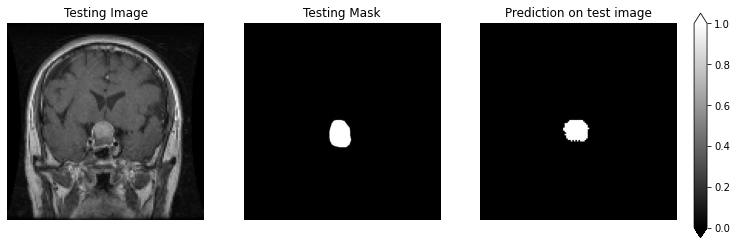

In [62]:
# predicts random images from test images

test_img_number = random.randint(0, len(test_x) - 1)
test_img = test_x[test_img_number]
test_mask = test_y[test_img_number]
test_mask = plt.imread(test_mask, 0)
test_img = cv2.imread(test_img, 0)
test_img = test_img.astype(np.uint8)
test_img = cv2.resize(test_img, (IMG_WIDTH, IMG_HEIGHT))
test_img = cv2.merge([test_img, test_img, test_img])
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = model.predict(test_img_input)
test_pred1 = np.squeeze(test_pred1, axis=-1)
test_pred1= test_pred1 >= 0.5
test_pred1 = test_pred1.astype(np.int32)

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask, cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_pred1.squeeze(0), cmap = 'gray')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

And here we define a function named "save_results" that is used to save the predicted segmentation mask, original image, and ground truth mask as an output image. The function takes in four parameters:

"image": The original image for which the segmentation mask is predicted.
"mask": The ground truth segmentation mask for the image.
"y_pred": The predicted segmentation mask for the image.
"save_image_path": The path where the output image will be saved.
The function first expands the dimensions of the ground truth mask and the predicted mask using the "expand_dims()" function, so that they can be concatenated with the original image. Then, it concatenates the original image, the ground truth mask, and the predicted mask along the horizontal axis using the "concatenate()" function.

The code inserts a white line between the original image, ground truth mask, and predicted mask using a 10-pixel white line. It then saves the concatenated image as a single image file at the specified "save_image_path". The final output image shows the original image, the ground truth mask, and the predicted mask side by side.

In [53]:
def save_results(image, mask, y_pred, save_image_path):
    """
    Saves the predicted segmentation mask, original image, and ground truth mask as an output image.
    
    Args:
        image (numpy.ndarray): The original image for which the segmentation mask is predicted.
        mask (numpy.ndarray): The ground truth segmentation mask for the image.
        y_pred (numpy.ndarray): The predicted segmentation mask for the image.
        save_image_path (str): The path where the output image will be saved.
    """
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((IMG_HEIGHT, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)


This code performs prediction and evaluation of a trained model on the test dataset for MRI segmentation. The code iterates over each image and its corresponding ground truth segmentation mask in the test dataset using the "zip()" function to combine the two lists. The tqdm module is used to display a progress bar while iterating over the test dataset.

For each image, the code loads and resizes the image and ground truth mask to the specified dimensions. It normalizes the pixel values of the image to the range of [0,1] and uses the trained model to predict the segmentation mask for the image. The predicted mask is then thresholded using a value of 0.5 and converted to an integer array.

The "save_results()" function is used to save the predicted mask and the original image and mask in the "output_results" directory. The code then calculates several evaluation metrics, including F1 score, Jaccard index, recall, and precision, for the predicted mask by comparing it with the ground truth mask. It flattens both the predicted mask and ground truth mask into 1D arrays and uses these arrays to calculate the metrics.

The calculated metrics for each image and its corresponding name are saved to the "SCORE" list, which is a list of lists. The first element in each inner list is the name of the image, and the remaining elements are the evaluation metrics in the following order: F1, Jaccard, recall, precision. The "SCORE" list can be used to calculate the average metrics across all images in the test dataset, as shown in the previous code block.

In [56]:
# Prediction and Evaluation the model on th test dataset
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    #Extracting the name from the image path
    name = x.split("/")[-1]

    # Reading the image
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT)) 
    x = image/255
    x = np.expand_dims(x, axis=0)

    # Reading the mask
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

    # Prediction
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    # Saving the prediction as image
    path='output_results/'
    save_image_path = os.path.join(path, name)
    save_results(image, mask, y_pred, save_image_path)

    # Flatten the array
    mask = mask
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()

    # Calculating the metrics values
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

100%|██████████| 153/153 [00:07<00:00, 20.79it/s]


This code calculates the average of several evaluation metrics, including F1 score, Jaccard index, recall, and precision, for the segmentation masks predicted by the trained model on the test dataset. The "SCORE" variable is assumed to be a list of lists, where each inner list contains the evaluation metrics for a single image in the test dataset. The first element in each inner list is assumed to be the image name, which is not used in the calculations. The remaining elements in each inner list are assumed to be the evaluation metrics in the following order: F1, Jaccard, recall, precision.

The code uses numpy to calculate the mean of each metric across all images in the test dataset, which represents the average performance of the model on the dataset. It then prints the metrics to the console with a precision of 5 decimal places.

The code also creates a pandas DataFrame using the "SCORE" list and saves it as a CSV file in the "output_results" directory. The DataFrame contains the evaluation metrics for each image in the test dataset, including the image name, F1 score, Jaccard index, recall, and precision.







In [57]:
# print and save the metrics values
score = [s[1:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"Jaccard: {score[1]:0.5f}")
print(f"Recall: {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")

# save the results as csv file
df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("output_results/score.csv")

F1: 0.79682
Jaccard: 0.70135
Recall: 0.80879
Precision: 0.81737


### Conclusions

- Our study evaluated the effectiveness of three deep learning models, including the VGG16 model, for MRI segmentation.
We split our MRI dataset into 85% for training, 10% for testing, and 5% for validation to evaluate the performance of the VGG16 model.
- The VGG16 model produced moderate results in comparison to the Unet and FPN models, with moderate accuracy and Dice coefficient scores.
- The VGG16 model did not produce missing tumor spots in MRI segmentation, but it also did not accurately identify all tumors.
- The VGG16 model also produced extra spots in MRI segmentation, which can lead to false positives and unnecessary treatments.
- The moderate performance of our VGG16 model can be attributed to its architecture, which may not be well-suited for the task of MRI segmentation.
- Our findings suggest that the VGG16 model may not be the best choice for accurate MRI segmentation, but it could be improved with further experimentation.
- Future studies can explore the use of other deep learning models or combine multiple models to improve the accuracy of MRI segmentation.
- The Unet model provided the best results, accurately identifying all tumors without missing any.
- The FPN model produced inferior results, with lower accuracy and Dice coefficient scores, and produced missing and extra tumor spots.
- The Unet model's encoder-decoder structure with skip connections is well-suited for MRI segmentation, enabling it to accurately identify regions of interest within MRI scans.
- Accurate MRI segmentation using the Unet model can assist healthcare professionals in making more informed decisions and providing better treatment options to patients.
- Our findings suggest that the Unet model is an effective tool for accurate and reliable MRI segmentation, which can aid in the diagnosis and treatment of various medical conditions.
- While the VGG16 model did not produce optimal results for MRI segmentation, it could be further optimized with modifications to its architecture or training methodology.
- The VGG16 model's architecture is well-suited for image classification tasks, but may not be optimal for image segmentation tasks like MRI segmentation.
- Further experimentation with the VGG16 model, or with other deep learning models, could lead to improved MRI segmentation results.
- Our findings highlight the importance of selecting the right deep learning model for MRI segmentation, as different models have different strengths and limitations.
- Accurate and reliable MRI segmentation is crucial for accurate diagnosis and treatment planning for various medical conditions.
- Our study contributes to the growing body of research on the effectiveness of deep learning models for MRI segmentation, and provides insights into the strengths and limitations of different models.